# Cointegration Tests & Pairs Trading

## What is cointegration?
We have seen how a time series can have a unit root that creates a stochastic trend and makes the time series highly persistent. When we use such an integrated time series in their original, rather than in differenced, form as a feature in a linear regression model, its relationship with the outcome will often appear statistically significant, even though it is not. This phenomenon is called spurious regression (for details, see Chapter 18 in [Wooldridge, 2008](https://economics.ut.ac.ir/documents/3030266/14100645/Jeffrey_M._Wooldridge_Introductory_Econometrics_A_Modern_Approach__2012.pdf)). Therefore, the recommended solution is to difference the time series so they become stationary before using them in a model.

$$
x_t=(x_{1t},x_{2t})^T
$$

$$
\exists \beta=(\beta_1,\beta_2),\ s.t.z_t=\beta_1 x_{1t}+\beta_2 x_{2t}\ stationary
$$

A non-technical example is that of a drunken man on a random walk accompanied by his dog (on a leash). Both trajectories are non-stationary but cointegrated because the dog will occasionally revert to his owner. In the trading context, arbitrage constraints imply cointegration between spot and futures prices.

Cointegration differs from correlation: two series can be highly correlated but need not be cointegrated.

## Cointegration for Pairs Trading

Cointegration is very useful: if two or more asset price series tend to revert to a common mean, we can leverage deviations from the trend because they should imply future price moves in the opposite direction.

In this notebook, we will address how we can identify pairs with such a long-term stationary relationship, estimate the expected time for any disequilibrium to correct, and how to utilize these tools to implement and backtest a long-short pairs trading strategy. There are two approaches to testing for cointegration:
- The Engle-Granger two-step method
- The Johansen test

### The Engle-Granger two-step method

The Engle-Granger method is used to identify cointegration
relationships between two series. It involves both of the following:
1. Regressing one series on another to estimate the stationary long-term relationship
2. Applying an ADF unit-root test to the regression residual

The null hypothesis is that the residuals have a unit root and are integrated; if we can reject it, then we assume that the residuals are stationary and, thus, the series are cointegrated (Engle and Granger 1987).

A key benefit of this approach is that the regression coefficient represents the multiplier that renders the combination stationary, that is, mean-reverting. Unfortunately, the test results will differ, depending on which variable we consider independent, so that we try both ways and then pick the relation with the more negative test statistic that has the lower p-value.

Another downside is that this test is limited to pairwise relationships. The more complex Johansen procedure can identify significant cointegration among up to a dozen time series.

### The Johansen likelihood-ratio test

The Johansen procedure, in contrast, tests the restrictions imposed by cointegration on a VAR model, as discussed in the previous section. More specifically, after subtracting the target vector from both sides of a generic VAR(p) model, we obtain the error correction model (ECM) formulation:
$$
\Delta y_t = c+\Pi y_{t-1}+\Gamma_1 \Delta y_{t-1}+\cdots+\Gamma_p \Delta y_{t-p}+\epsilon_t
$$
The resulting modified VAR(p) equation has only one vector term in levels($y_{t-1}$) that is not expressed as a difference using the $\Delta$ operator. The nature of cointegration depends on the rank of the coefficient matrix of this term (Johansen 1991).

While this equation appears structurally similar to the ADF test setup, there are now several potential constellations of common trends because there are multiple series involved. To identify the number of cointegration relationships, the Johansen test successively tests for an increasing rank of , starting at 0 (no cointegration). We will explore the application to the case of two series in the following section.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from time import time
from pathlib import Path
from tqdm import tqdm 

import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import  DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [4]:
DATA_PATH = Path('..', 'data')
STORE = DATA_PATH / 'assets.h5'

### Johansen Test Critical Values

In [5]:
critical_values = {0: {.9: 13.4294, .95: 15.4943, .99: 19.9349},
                   1: {.9: 2.7055, .95: 3.8415, .99: 6.6349}}

In [6]:
trace0_cv = critical_values[0][.95] # critical value for 0 cointegration relationships
trace1_cv = critical_values[1][.95] # critical value for 1 cointegration relationship

## Load & Clean Stock & ETF Data

### Remove highly correlated assets

In [7]:
def remove_correlated_assets(df, cutoff=.99):
    corr = df.corr().stack()
    corr = corr[corr < 1]
    to_check = corr[corr.abs() > cutoff].index
    keep, drop = set(), set()
    for s1, s2 in to_check:
        if s1 not in keep:
            if s2 not in keep:
                keep.add(s1)
                drop.add(s2)
            else:
                drop.add(s1)
        else:
            keep.discard(s2)
            drop.add(s2)
    return df.drop(drop, axis=1)

### Remove stationary series

In [8]:
def check_stationarity(df):
    results = []
    for ticker, prices in df.items():
        results.append([ticker, adfuller(prices, regression='ct')[1]])
    return pd.DataFrame(results, columns=['ticker', 'adf']).sort_values('adf')

In [9]:
def remove_stationary_assets(df, pval=.05):
    test_result = check_stationarity(df)
    stationary = test_result.loc[test_result.adf <= pval, 'ticker'].tolist()
    return df.drop(stationary, axis=1).sort_index()

### Select Assets

In [10]:
def select_assets(asset_class='stocks', n=500, start=2010, end=2019):
    idx = pd.IndexSlice
    with pd.HDFStore(STORE) as store:
        df = (pd.concat([store[f'stooq/us/nasdaq/{asset_class}/prices'],
                         store[f'stooq/us/nyse/{asset_class}/prices']])
              # stooq download can have duplicate assets
              .loc[lambda df: ~df.index.duplicated()]
              .sort_index()
              .loc[idx[:, f'{start}':f'{end}'], :]
              .assign(dv=lambda df: df.close.mul(df.volume)))

    # select n assets with the highest average trading volume
    # we are taking a shortcut to simplify; should select
    # based on historical only, e.g. yearly rolling avg
    most_traded = (df.groupby(level='ticker')
                   .dv.mean()
                   .nlargest(n=n).index)

    df = (df.loc[idx[most_traded, :], 'close']
          .unstack('ticker')
          .ffill(limit=5)  # fill up to five values
          .dropna(axis=1))  # remove assets with any missing values

    df = remove_correlated_assets(df)
    return remove_stationary_assets(df).sort_index()

We store the intermediate result:

In [11]:
for asset_class, n in [('etfs', 500), ('stocks', 250)]:
    df = select_assets(asset_class=asset_class, n=n)
    df.to_hdf('data.h5', f'{asset_class}/close')

### Get ticker dictionary

In [7]:
def get_ticker_dict():
    with pd.HDFStore(STORE) as store:
        return (pd.concat([
            store['stooq/us/nyse/stocks/tickers'],
            store['stooq/us/nyse/etfs/tickers'],
            store['stooq/us/nasdaq/etfs/tickers'],
            store['stooq/us/nasdaq/stocks/tickers']
        ]).drop_duplicates().set_index('ticker').squeeze().to_dict())

In [8]:
names = get_ticker_dict()

## Visualize Correlation Clusters 

Reload intermediate results:

In [9]:
stocks = pd.read_hdf('data.h5', 'stocks/close')
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to ADSK.US
dtypes: float64(172)
memory usage: 3.3 MB


In [10]:
etfs = pd.read_hdf('data.h5', 'etfs/close')
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to IDX.US
dtypes: float64(132)
memory usage: 2.6 MB


In [11]:
tickers = {k: v for k, v in names.items() if k in etfs.columns.union(stocks.columns)}
pd.Series(tickers).to_hdf('data.h5', 'tickers')

In [12]:
corr = pd.DataFrame(index=stocks.columns)
for etf, data in etfs.items():
    corr[etf] = stocks.corrwith(data)

In [13]:
corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172 entries, AAPL.US to ADSK.US
Columns: 132 entries, SPY.US to IDX.US
dtypes: float64(132)
memory usage: 182.8+ KB


In [14]:
corr

,SPY.US,EEM.US,GLD.US,EFA.US,XLF.US,XLE.US,TLT.US,GDX.US,EWZ.US,HYG.US,...,TAN.US,IGOV.US,EPU.US,WIP.US,PJP.US,INDY.US,XPH.US,STPZ.US,BRF.US,IDX.US
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL.US,0.96,0.58,-0.27,0.87,0.95,0.30,0.83,-0.60,-0.41,0.92,...,-0.44,0.35,0.23,0.53,0.76,0.84,0.62,0.73,-0.49,-0.18
AMZN.US,0.93,0.59,-0.27,0.82,0.92,0.21,0.74,-0.52,-0.31,0.86,...,-0.38,0.38,0.29,0.46,0.66,0.83,0.48,0.66,-0.41,-0.17
MSFT.US,0.94,0.58,-0.26,0.82,0.92,0.19,0.77,-0.52,-0.29,0.88,...,-0.33,0.39,0.25,0.48,0.65,0.84,0.48,0.69,-0.39,-0.17
BAC.US,0.91,0.67,-0.47,0.88,0.95,0.26,0.62,-0.58,-0.26,0.85,...,-0.18,0.31,0.24,0.42,0.66,0.88,0.51,0.50,-0.39,-0.22
GOOGL.US,0.98,0.53,-0.40,0.90,0.98,0.32,0.82,-0.69,-0.49,0.94,...,-0.44,0.37,0.16,0.49,0.81,0.84,0.65,0.67,-0.58,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CLF.US,-0.75,-0.08,0.58,-0.72,-0.73,-0.43,-0.79,0.93,0.84,-0.80,...,0.56,-0.16,0.28,-0.40,-0.90,-0.47,-0.86,-0.49,0.85,0.44
FITB.US,0.96,0.63,-0.42,0.94,0.98,0.45,0.74,-0.70,-0.43,0.94,...,-0.41,0.38,0.24,0.56,0.79,0.82,0.66,0.65,-0.52,-0.19
GEN.US,0.82,0.54,-0.37,0.82,0.85,0.38,0.69,-0.63,-0.42,0.83,...,-0.44,0.31,0.19,0.52,0.71,0.73,0.60,0.57,-0.48,-0.07


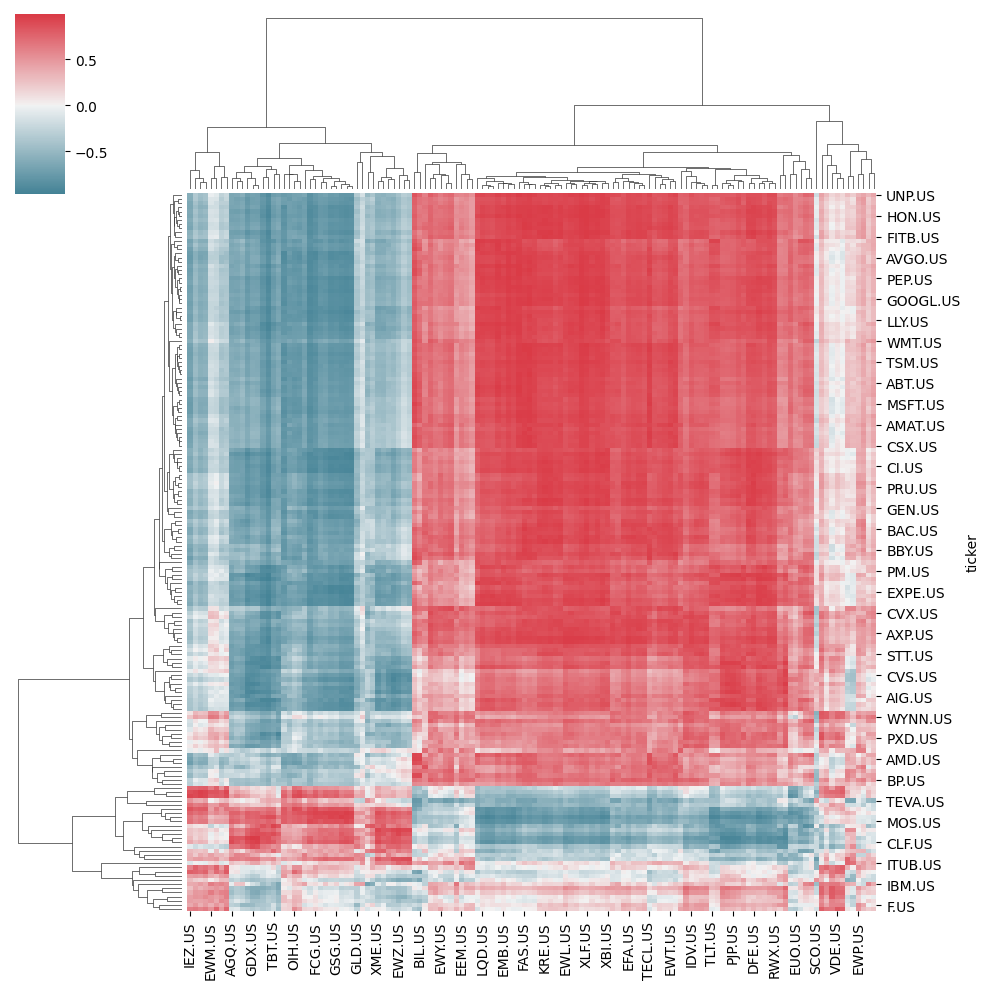

In [15]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.clustermap(corr, cmap=cmap, center=0);

## Candidate Selection using Heuristics

### Computational Complexity: Comparing running times

In this section, we compare the running times of various cointegration tests. More specifically, we are running tests for a single asset vs. the remaining set of securities.

#### Prepare Data

In [16]:
stocks.shape, etfs.shape

((2516, 172), (2516, 132))

In [17]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 172 entries, AAPL.US to ADSK.US
dtypes: float64(172)
memory usage: 3.3 MB


In [18]:
etfs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Columns: 132 entries, SPY.US to IDX.US
dtypes: float64(132)
memory usage: 2.6 MB


In [19]:
security = etfs['AAXJ.US'].loc['2010': '2013']
candidates = stocks.loc['2010': '2013']

In [24]:
security = security.div(security.iloc[0])
candidates = candidates.div(candidates.iloc[0])
spreads = candidates.sub(security, axis=0)

In [33]:
n, m = spreads.shape
X = np.ones(shape=(n, 2))
X[:, 1] = np.arange(1, n+1)

#### Heuristics

In [34]:
%%timeit
np.linalg.inv(X.T @ X) @ X.T @ spreads

875 µs ± 20.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
%%timeit
spreads.std()

561 µs ± 6.95 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
%%timeit
candidates.corrwith(security)

37.8 ms ± 835 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Cointegration Tests

In [29]:
%%timeit
for candidate, prices in candidates.items():
    df = pd.DataFrame({'s1': security,
                       's2': prices})
    var = VAR(df.values)
    lags = var.select_order()
    k_ar_diff = lags.selected_orders['aic']
    coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
    coint(security, prices, trend='c')[:2]
    coint(prices, security, trend='c')[:2]

33.1 s ± 192 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Clearly, cointegration tests are significantly more costly. It would be great if the heuristics worked just as well, or at least 'good enough'.

### Compute Heuristics

The function `compute_pair_metrics()` computes the following distance metrics for over 23,000 pairs of
stocks and Exchange Traded Funds (ETFs) for 2019-1 and 2019-12:

- The **drift of the spread**, defined as a linear regression of a time trend on the spread
- The spread's  **volatility**
- The **correlations** between the normalized price series and between their returns

Low drift and volatility, as well as high correlation, are simple proxies for cointegration. 

To evaluate the predictive power of these heuristics, we also run Engle-Granger and Johansen **cointegration tests** using `statsmodels` for the preceding pairs. This takes place in the loop in the second half of `compute_pair_metrics()`.

We first estimate the optimal number of lags that we need to specify for the Johansen test. For both tests, we assume that the cointegrated series (the spread) may have an intercept different from zero but no trend:

In [52]:
def compute_pair_metrics(security, candidates):
    security = security.div(security.iloc[0])
    ticker = security.name
    candidates = candidates.div(candidates.iloc[0])
    spreads = candidates.sub(security, axis=0)
    n, m = spreads.shape
    X = np.ones(shape=(n, 2))
    X[:, 1] = np.arange(1, n + 1)
    
    # compute drift
    drift = ((np.linalg.inv(X.T @ X) @ X.T @ spreads).iloc[1]
             .to_frame('drift'))
    
    # compute volatility
    vol = spreads.std().to_frame('vol')
    
    # return correlation
    corr_ret = (candidates.pct_change()
                .corrwith(security.pct_change())
                .to_frame('corr_ret'))
    
    # normalized price series correlation
    corr = candidates.corrwith(security).to_frame('corr')
    metrics = drift.join(vol).join(corr).join(corr_ret).assign(n=n)
    
    tests = []
    # run cointegration tests
    for candidate, prices in tqdm(candidates.items()):
        df = pd.DataFrame({'s1': security, 's2': prices})
        var = VAR(df.values)
        lags = var.select_order() # select VAR order
        k_ar_diff = lags.selected_orders['aic']
        # Johansen Test with constant Term and estd. lag order
        cj0 = coint_johansen(df, det_order=0, k_ar_diff=k_ar_diff)
        # Engle-Granger Tests
        t1, p1 = coint(security, prices, trend='c')[:2]
        t2, p2 = coint(prices, security, trend='c')[:2]
        tests.append([ticker, candidate, t1, p1, t2, p2, 
                      k_ar_diff, *cj0.lr1])
    columns = ['s1', 's2', 't1', 'p1', 't2', 'p2', 'k_ar_diff', 'trace0', 'trace1']
    tests = pd.DataFrame(tests, columns=columns).set_index('s2')
    return metrics.join(tests)

In [53]:
spreads = []
start = "2019"
stop = "2019"
etf_candidates = etfs.loc[start: stop, :]
stock_candidates = stocks.loc[start: stop,:]
s = time()
for i, (etf_ticker, etf_prices) in enumerate(etf_candidates.items(), 1):
    df = compute_pair_metrics(etf_prices, stock_candidates)
    spreads.append(df.set_index('s1', append=True))
    if i % 10 == 0:
        print(f'\n{i:>3} {time() - s:.1f}\n')
        s = time()

172it [00:05, 30.75it/s]
172it [00:05, 30.98it/s]
172it [00:05, 31.12it/s]
172it [00:05, 31.11it/s]
172it [00:05, 30.38it/s]
172it [00:05, 31.05it/s]
172it [00:05, 30.45it/s]
172it [00:05, 30.75it/s]
172it [00:05, 30.50it/s]
172it [00:05, 31.23it/s]



 10 57.2



172it [00:05, 31.39it/s]
172it [00:05, 30.63it/s]
172it [00:05, 31.17it/s]
172it [00:05, 31.30it/s]
172it [00:05, 29.13it/s]
172it [00:05, 30.27it/s]
172it [00:05, 29.55it/s]
172it [00:05, 31.12it/s]
172it [00:05, 31.33it/s]
172it [00:05, 31.30it/s]



 20 56.9



172it [00:05, 31.26it/s]
172it [00:05, 31.23it/s]
172it [00:05, 31.16it/s]
172it [00:05, 30.66it/s]
172it [00:05, 30.78it/s]
172it [00:05, 31.63it/s]
172it [00:05, 31.57it/s]
172it [00:05, 31.58it/s]
172it [00:05, 31.45it/s]
172it [00:05, 31.77it/s]



 30 55.8



172it [00:05, 30.38it/s]
172it [00:06, 27.74it/s]
172it [00:05, 31.16it/s]
172it [00:05, 30.62it/s]
172it [00:05, 30.89it/s]
172it [00:05, 31.47it/s]
172it [00:05, 30.57it/s]
172it [00:05, 29.99it/s]
172it [00:05, 30.35it/s]
172it [00:05, 30.15it/s]



 40 57.6



172it [00:05, 30.48it/s]
172it [00:05, 30.17it/s]
172it [00:05, 30.64it/s]
172it [00:05, 30.41it/s]
172it [00:05, 30.15it/s]
172it [00:05, 29.88it/s]
172it [00:05, 30.35it/s]
172it [00:05, 30.35it/s]
172it [00:05, 30.06it/s]
172it [00:05, 30.14it/s]



 50 57.7



172it [00:06, 28.33it/s]
172it [00:06, 28.35it/s]
172it [00:06, 26.92it/s]
172it [00:05, 30.28it/s]
172it [00:06, 28.20it/s]
172it [00:05, 30.70it/s]
172it [00:05, 29.58it/s]
172it [00:05, 30.43it/s]
172it [00:05, 30.19it/s]
172it [00:05, 30.14it/s]



 60 59.7



172it [00:05, 30.92it/s]
172it [00:05, 31.00it/s]
172it [00:05, 30.52it/s]
172it [00:05, 31.04it/s]
172it [00:05, 31.02it/s]
172it [00:05, 31.52it/s]
172it [00:05, 30.82it/s]
172it [00:05, 30.42it/s]
172it [00:05, 31.07it/s]
172it [00:05, 30.97it/s]



 70 56.5



172it [00:05, 30.91it/s]
172it [00:05, 30.94it/s]
172it [00:05, 31.35it/s]
172it [00:05, 31.38it/s]
172it [00:05, 31.00it/s]
172it [00:05, 30.45it/s]
172it [00:05, 31.22it/s]
172it [00:05, 31.37it/s]
172it [00:05, 31.05it/s]
172it [00:05, 30.89it/s]



 80 56.2



172it [00:05, 30.49it/s]
172it [00:05, 29.54it/s]
172it [00:05, 30.51it/s]
172it [00:05, 30.52it/s]
172it [00:05, 30.63it/s]
172it [00:05, 29.72it/s]
172it [00:06, 26.42it/s]
172it [00:05, 29.53it/s]
172it [00:05, 30.27it/s]
172it [00:05, 30.33it/s]



 90 58.7



172it [00:05, 30.30it/s]
172it [00:05, 30.04it/s]
172it [00:05, 30.14it/s]
172it [00:05, 29.73it/s]
172it [00:05, 29.83it/s]
172it [00:05, 29.65it/s]
172it [00:05, 29.80it/s]
172it [00:05, 29.71it/s]
172it [00:05, 29.89it/s]
172it [00:05, 31.00it/s]



100 58.2



172it [00:05, 30.20it/s]
172it [00:05, 29.55it/s]
172it [00:05, 29.51it/s]
172it [00:05, 30.30it/s]
172it [00:05, 30.33it/s]
172it [00:05, 30.07it/s]
172it [00:05, 30.61it/s]
172it [00:05, 31.16it/s]
172it [00:05, 30.75it/s]
172it [00:05, 30.77it/s]



110 57.6



172it [00:05, 30.40it/s]
172it [00:05, 30.52it/s]
172it [00:05, 31.25it/s]
172it [00:05, 31.31it/s]
172it [00:05, 31.09it/s]
172it [00:05, 31.12it/s]
172it [00:05, 30.81it/s]
172it [00:05, 30.02it/s]
172it [00:05, 30.60it/s]
172it [00:05, 31.10it/s]



120 56.7



172it [00:05, 30.95it/s]
172it [00:05, 30.58it/s]
172it [00:05, 29.65it/s]
172it [00:05, 30.76it/s]
172it [00:05, 31.14it/s]
172it [00:05, 31.39it/s]
172it [00:05, 31.48it/s]
172it [00:05, 31.18it/s]
172it [00:05, 31.54it/s]
172it [00:05, 31.09it/s]



130 56.4



172it [00:05, 31.29it/s]
172it [00:05, 30.97it/s]


In [54]:
names = get_ticker_dict()
spreads = pd.concat(spreads)
spreads.index.names = ['s2', 's1']
spreads = spreads.swaplevel()
spreads['name1'] = spreads.index.get_level_values('s1').map(names)
spreads['name2'] = spreads.index.get_level_values('s2').map(names)

In [55]:
spreads['t'] = spreads[['t1', 't2']].min(axis=1)
spreads['p'] = spreads[['p1', 'p2']].min(axis=1)

### Engle-Granger vs Johansen: how do their findings compare?

To check for the significance of the cointegration tests, we compare the Johansen trace statistic for rank 0 and 1 to their respective critical values and obtain the Engle-Granger p-value.

We follow the recommendation by Gonzalo and Lee (1998) to apply both tests and accept pairs where they agree. The authors suggest additional due diligence in case of disagreement, which we are going to skip.

In [81]:
spreads['trace_sig'] = ((spreads.trace0 > trace0_cv) &
                        (spreads.trace1 > trace1_cv)).astype(int)
spreads['eg_sig'] = (spreads.p < .05).astype(int)

For the over 22,704 pairs across both sample periods, the Johansen test considers 8.35 percent of the relationships as significant, while the Engle-Granger considers 15.17 percent. They agree on 630 pairs (results may change with new data downloaded from stooq).

In [82]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,17994,1266
1,2814,630


In [83]:
spreads['coint'] = (spreads.trace_sig & spreads.eg_sig).astype(int)

In [84]:
spreads.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 22704 entries, ('SPY.US', 'AAPL.US') to ('IDX.US', 'ADSK.US')
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drift      22704 non-null  float64
 1   vol        22704 non-null  float64
 2   corr       22704 non-null  float64
 3   corr_ret   22704 non-null  float64
 4   n          22704 non-null  int64  
 5   t1         22704 non-null  float64
 6   p1         22704 non-null  float64
 7   t2         22704 non-null  float64
 8   p2         22704 non-null  float64
 9   k_ar_diff  22704 non-null  int64  
 10  trace0     22704 non-null  float64
 11  trace1     22704 non-null  float64
 12  name1      22704 non-null  object 
 13  name2      22704 non-null  object 
 14  t          22704 non-null  float64
 15  p          22704 non-null  float64
 16  trace_sig  22704 non-null  int32  
 17  eg_sig     22704 non-null  int32  
 18  coint      22704 non-null  int32  
dtypes: float64

In [85]:
spreads = spreads.reset_index()

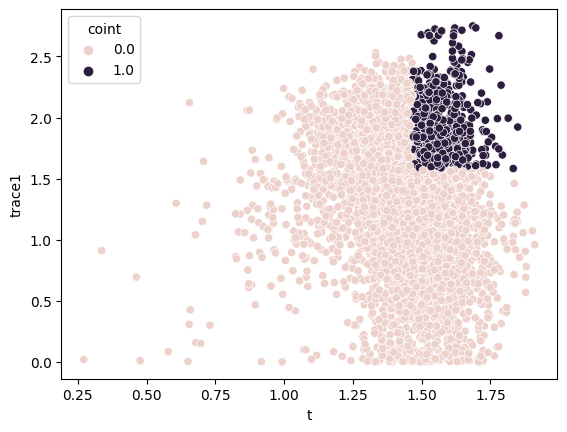

In [86]:
sns.scatterplot(x=np.log1p(spreads.t.abs()), 
                y=np.log1p(spreads.trace1), 
                hue='coint', data=spreads[spreads.trace0>trace0_cv]);

In [87]:
spreads.to_hdf('heuristics.h5', 'spreads')

In [59]:
spreads = pd.read_hdf('heuristics.h5', 'spreads')

In [70]:
spreads

,s1,s2,drift,vol,corr,corr_ret,n,t1,p1,t2,...,k_ar_diff,trace0,trace1,name1,name2,t,p,trace_sig,eg_sig,coint
0,SPY.US,AAPL.US,0.00,0.16,0.95,0.74,252,-4.10,0.01,-3.32,...,1,20.42,0.96,SPDR S&P 500 ETF TRUST,APPLE,-4.10,0.01,0,1,0
1,SPY.US,AMZN.US,-0.00,0.07,0.49,0.73,252,-0.39,0.97,-1.82,...,1,13.59,0.26,SPDR S&P 500 ETF TRUST,AMAZON.COM,-1.82,0.62,0,0,0
2,SPY.US,MSFT.US,0.00,0.09,0.96,0.81,252,-2.80,0.17,-2.46,...,1,13.01,1.44,SPDR S&P 500 ETF TRUST,MICROSOFT,-2.80,0.17,0,0,0
3,SPY.US,BAC.US,0.00,0.06,0.82,0.67,252,-2.01,0.52,-1.75,...,1,8.87,1.76,SPDR S&P 500 ETF TRUST,BANK OF AMERICA,-2.01,0.52,0,0,0
4,SPY.US,GOOGL.US,-0.00,0.04,0.82,0.67,252,-2.36,0.35,-2.39,...,1,11.32,5.05,SPDR S&P 500 ETF TRUST,ALPHABET,-2.39,0.33,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22699,IDX.US,CLF.US,-0.00,0.16,0.37,0.31,252,-2.67,0.21,-1.95,...,1,17.36,5.68,VANECK INDONESIA ETF,CLEVELAND-CLIFFS,-2.67,0.21,1,0,0
22700,IDX.US,FITB.US,0.00,0.08,0.13,0.29,252,-2.63,0.23,-1.89,...,1,13.86,4.69,VANECK INDONESIA ETF,FIFTH THIRD BANCORP,-2.63,0.23,0,0,0
22701,IDX.US,GEN.US,0.00,0.10,0.21,0.19,252,-2.68,0.21,-2.06,...,1,14.68,5.73,VANECK INDONESIA ETF,GEN DIGITAL,-2.68,0.21,0,0,0
22702,IDX.US,GPS.US,-0.00,0.14,0.27,0.13,252,-2.76,0.18,-1.55,...,1,15.96,2.01,VANECK INDONESIA ETF,GAP,-2.76,0.18,0,0,0


### Evaluate Heuristics

In [71]:
spreads.drift = spreads.drift.abs()

In [72]:
pd.crosstab(spreads.eg_sig, spreads.trace_sig)

trace_sig,0,1
eg_sig,,
0,17994,1266
1,2814,630


In [73]:
pd.set_option('display.float_format', lambda x: f'{x:.2%}')
pd.crosstab(spreads.eg_sig, spreads.trace_sig, normalize=True)

trace_sig,0,1
eg_sig,,
0,79.25%,5.58%
1,12.39%,2.77%


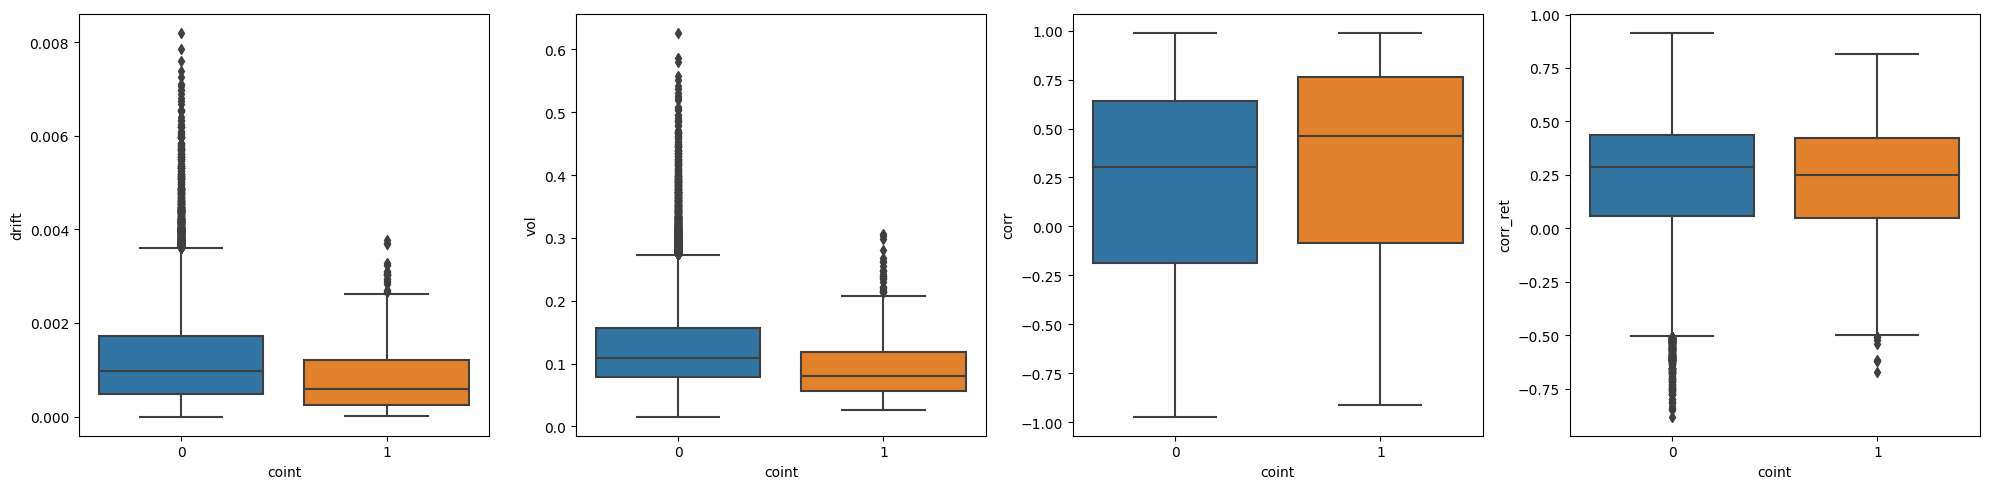

In [74]:
fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for i, heuristic in enumerate(['drift', 'vol', 'corr', 'corr_ret']):
    sns.boxplot(x='coint', y=heuristic, data=spreads, ax=axes[i])
fig.tight_layout();

### How well do the heuristics predict significant cointegration?

When we compare the distributions of the heuristics for series that are cointegrated according to both tests with the remainder that is not, volatility and drift are indeed lower (in absolute terms). Figure 9.14 shows that the picture is less clear for the two correlation measures:

In [75]:
spreads.groupby(spreads.coint)['drift', 'vol', 'corr'].describe().stack(level=0).swaplevel().sort_index()

25%    50%    75%       count    max   mean     min    std
      coint                                                               
corr  0     -18.73% 30.58% 63.91% 2207400.00% 98.91% 20.60% -97.06% 51.30%
      1      -8.51% 46.42% 76.27%   63000.00% 98.76% 30.09% -91.32% 55.92%
drift 0       0.05%  0.10%  0.17% 2207400.00%  0.82%  0.12%   0.00%  0.10%
      1       0.02%  0.06%  0.12%   63000.00%  0.38%  0.08%   0.00%  0.08%
vol   0       7.92% 10.85% 15.70% 2207400.00% 62.66% 12.65%   1.58%  6.66%
      1       5.58%  7.97% 11.85%   63000.00% 30.61%  9.47%   2.55%  5.27%

In [76]:
spreads.coint.value_counts()

0    22074
1      630
Name: coint, dtype: int64

#### Logistic Regression

In [77]:
y = spreads.coint
X = spreads[['drift', 'vol', 'corr', 'corr_ret']]
# X = spreads[['drift', 'vol']]

In [78]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

In [79]:
log_reg = LogisticRegressionCV(Cs=np.logspace(-10, 10, 21), 
                               class_weight='balanced',
                               scoring='roc_auc')

'C:3.00, AUC: 66.16%'

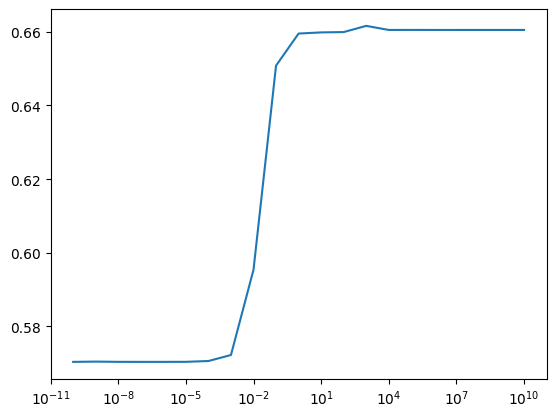

In [80]:
log_reg.fit(X=X, y=y)
Cs = log_reg.Cs_
scores = pd.DataFrame(log_reg.scores_[True], columns=Cs).mean()
scores.plot(logx=True);
f'C:{np.log10(scores.idxmax()):.2f}, AUC: {scores.max():.2%}'

In [81]:
log_reg.coef_

array([[ 1.13884957e+02, -1.23835244e+01, -8.74269283e-02,
        -8.01512055e-01]])

In [82]:
y_pred = log_reg.predict_proba(X)[:, 1]
confusion_matrix(y_true=spreads.coint, y_pred=(y_pred>.5))

array([[11398, 10676],
       [  189,   441]], dtype=int64)

In [83]:
spreads.assign(y_pred=log_reg.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2207400.00%,46.08%,14.50%,0.39%,37.26%,49.44%,56.56%,79.63%
1,63000.00%,53.92%,12.05%,11.85%,48.37%,56.81%,62.04%,77.19%


#### Decision Tree Classifier

In [89]:
model = DecisionTreeClassifier(class_weight='balanced')
decision_tree = GridSearchCV(model,
                             param_grid={'max_depth': list(range(1, 10))},
                             cv=5,
                             scoring='roc_auc')

In [90]:
decision_tree.fit(X=X, y=y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='roc_auc')

In [91]:
f'{decision_tree.best_score_:.2%}, Depth: {decision_tree.best_params_["max_depth"]}'

'69.73%, Depth: 4'

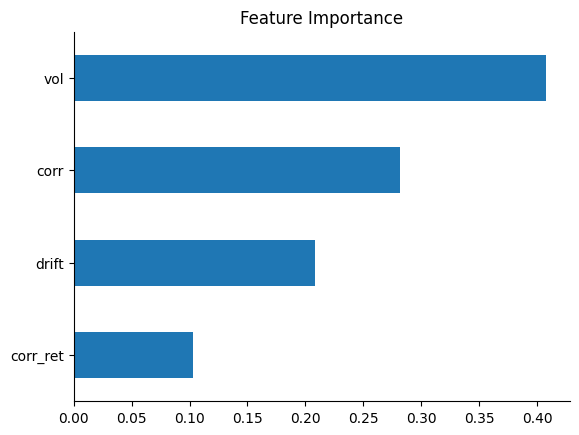

In [92]:
pd.Series(data=decision_tree.best_estimator_.feature_importances_, 
          index=X.columns).sort_values().plot.barh(title='Feature Importance')
sns.despine();

In [94]:
spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]).groupby(spreads.coint).y_pred.describe()

,count,mean,std,min,25%,50%,75%,max
coint,,,,,,,,
0,2207400.00%,39.75%,18.78%,0.00%,23.91%,39.52%,45.23%,91.13%
1,63000.00%,60.25%,21.51%,23.91%,45.23%,65.87%,77.91%,91.13%


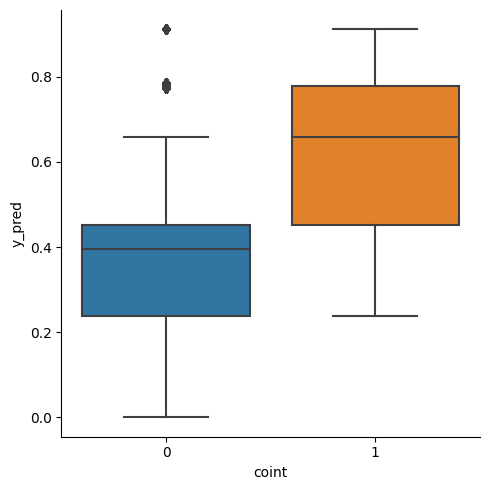

In [95]:
sns.catplot(x='coint', 
            y='y_pred', 
            data=spreads.assign(y_pred=decision_tree.predict_proba(X)[:, 1]), 
            kind='box');